In [174]:
using DifferentialEquations, Optim, Plots, DataFrames, LinearAlgebra, CSV, BenchmarkTools

### Data

##### Sample Data

In [175]:
# Import sample data
sample_IM = DataFrame(CSV.File("C:/Users/Aidan/Documents/GitHub/BioCyb/thyrosimIM/data/DDR_initials.csv")); # DDR Hashimoto Steady-State
patient_list = [7228995, 62352978, 78490026, 1179621568, 1708857679]
sample_IM.t = 12 * sample_IM.t;

##### Import Patient Data

In [176]:
function normalize_time(labs_df, dose_df)
    t_0 = min(minimum(labs_df.t), minimum(dose_df.t))
    labs_df.t = (labs_df.t .- t_0).*24
    dose_df.t = (dose_df.t .- t_0).*24
    patient_data = (labs_df, dose_df)
    return patient_data
end

function import_patient(patient_ID)
    data_dir = "C:/Users/Aidan/Documents/GitHub/BioCyb/thyrosimIM/data/Parsed_data/"
    info_path = data_dir * "patient-$patient_ID.txt"
    labs_path = data_dir * "patient-$patient_ID.csv"
    dose_path = data_dir * "patient_meds-$patient_ID.csv"
    labs_df = DataFrame(CSV.File(labs_path))
    dose_df = DataFrame(CSV.File(dose_path))

    patient_data = normalize_time(labs_df, dose_df)
    return patient_data
end

import_patient (generic function with 1 method)

In [177]:
patient = import_patient(patient_list[3])
labs_df = patient[1]
dose_df = patient[2];

##### Patient Plotting

In [178]:
function plot_patient(patient; title::String="Patient Labs")
    labs = patient[1]
    meds = patient[2]

    T4T3Labels = ["FT4 (ng/dL)", "FT3 (pg/dL)"]
    T4T3Ranges = [[0.9, 2.3], [260, 480]]
    xlims = (min(minimum(labs.t), minimum(labs.t)), max(maximum(labs.t), maximum(meds.t)))
    
    p1 = plot(labs.t, labs.T4, label="T4", xlim=xlims, ylabel=T4T3Labels[1])
    p1 = plot!(twinx(), meds.Levothyroxine, label="", color = "red", xticks=:none)
    p1 = hline!(T4T3Ranges[1], label= "")
    p1 = scatter!(labs.t, labs.T4, alpha = 0.3, label="")
    
    p2 = plot(labs.t, labs.T3, label="", xlim=xlims, ylabel=T4T3Labels[2], title=title)
    p2 = plot!(twinx(), meds.Lyothyronine, label="", color = "red", xticks=:none)
    p2 = hline!(T4T3Ranges[2], label= "")
    p2 = scatter!(labs.t, labs.T3, alpha = 0.3, label="")
    
    p3 = plot(labs.t, labs.TSH, label="", xlim=xlims, ylabel="TSH (mU/L)")
    p3 = hline!([0.45, 4.5], label= "")
    p3 = scatter!(labs.t, labs.TSH, alpha = 0.3)

    p4 = plot(labs.t, labs.Lymphocytes, xlim=xlims, ylabel="Lymphocytes (cell/mL)", label="Lymphocytes")
    p4 = scatter!(labs.t, labs.Lymphocytes, alpha = 0.3)

    p5 = plot(labs.t, labs.Ab, ylabel="TPOAb (IU/mL)", xlim=xlims, xlabel="time [days]", label="")
    p5 = scatter!(labs.t, labs.Ab, alpha = 0.3)

        
    plot!(size=(900,900))
    plot(p1, p2, p3, p4, p5, layout=(2, 3))

end

plot_patient (generic function with 1 method)

# Problem with 24 hour conversion... need to fix

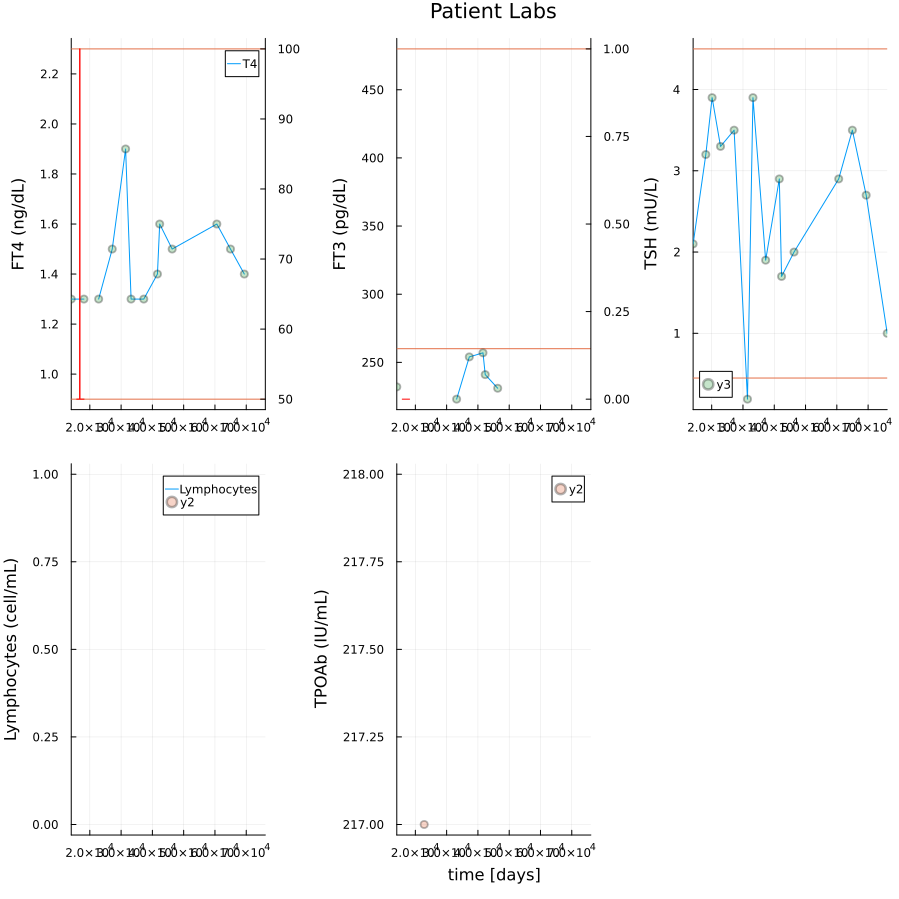

In [179]:
#fix layouts with layout(grid...) constructor
plot_patient(patient)

### Parameters

In [182]:
# Placeholder until some way to pass fixed, free parameters separatley is implemented
function fixed_parameters()

    dial=[1.0; 0.88; 1.0; 0.88]
    p = zeros(Float64, 82)
    p[1] = 0.0027785399344 #S4
    p[2] = 8               #tau
    p[3] = 0.868           #k12
    p[4] = 0.108           #k13
    p[5] = 584             #k31free
    p[6] = 1503            #k21free
    p[7] = 0.000289        #A
    p[8] = 0.000214        #B
    p[9] = 0.000128        #C
    p[10] = -8.83*10^-6    #D
    p[11] = 0.88           #k4absorb
    p[12] = 0.0189         #k02
    p[13] = 0.012101809339 #VmaxD1fast
    p[14] = 2.85           #KmD1fast
    p[15] = 6.63*10^-4     #VmaxD1slow
    p[16] = 95             #KmD1slow
    p[17] = 0.00074619     #VmaxD2slow
    p[18] = 0.075          #KmD2slow
    p[19] = 3.3572*10^-4   #S3
    p[20] = 5.37           #k45
    p[21] = 0.0689         #k46
    p[22] = 127            #k64free
    p[23] = 2043           #k54free
    p[24] = 0.00395        #a
    p[25] = 0.00185        #b
    p[26] = 0.00061        #c
    p[27] = -0.000505      #d
    p[28] = 0.88           #k3absorb
    p[29] = 0.184972339613 #k05
    p[30] = 450            #Bzero
    p[31] = 219.7085301388 #Azero
    p[32] = 0              #Amax
    p[33] = -3.71          #phi
    p[34] = 0.53           #kdegTSH-HYPO
    p[35] = 0.226          #VmaxTSH
    p[36] = 23             #K50TSH
    p[37] = 0.058786935033 #k3
    p[38] = 0.29           #T4P-EU
    p[39] = 0.006          #T3P-EU
    p[40] = 0.037          #KdegT3B
    p[41] = 0.0034         #KLAG-HYPO
    p[42] = 5              #KLAG
    p[43] = 1.3            #k4dissolve
    p[44] = 0.12           #k4excrete
    p[45] = 1.78           #k3dissolve
    p[46] = 0.12           #k3excrete
    p[47] = 3.2            #Vp
    p[48] = 5.2            #VTSH
    p[49] = 3.001011022378 #K_circ
    p[50] = 3.094711690204 #K_SR_tsh
    p[51] = 5.674773816316 #n_hillcirc
    p[52] = 6.290803221796 #m_hillTSH
    p[53] = 8.498343729591 #K_f4 for f4
    p[54] = 14.36664496926 #l_hillf3
    p[57] = dial[1] # controls T4 secretion rate
    p[58] = dial[2] # controls T4 excretion rate
    p[59] = dial[3] # controls T3 secretion rate
    p[60] = dial[4] # controls T3 excretion rate
    p[61] = 5.003761571969437   # σT4
    p[62] = 0.11122955089297369 # σT3
    p[63] = 0.4                 # σTSH
    p[64] = 0.1                 # σFT4
    p[65] = 21.82854404275587 # maleBMI_ref
    p[66] = 22.99050845201536 # femaleBMI_ref
    p[67] = 1.0 #Vtsh_scale
    p[69] = 1.0 # PV_ratio
    p[70] = -1.0 # PV
    p[71] = 1.0 # PV_allometric_exp
    p[72] = 1.0 # fat_free
    p[73] = 0.0 # fat
    p[74] = 1.0 # slow_scale
    p[75] = 1.0 # fast_scale
    p[76] = 0.75 # male_allometric
    p[77] = 0.75 # female_allometric
    p[78] = 1.7608716659237555 # male_ref_height
    p[79] = 1.6696106891941103 # female_ref_height
    p[80] = 1.0499391485135692 # male_clearace
    p[81] = 0.0 # T4 infusion
    p[82] = 0.0 # T3 infusion

    return p
end

function ics()
    ic    = zeros(Float64, 25)
    ic[1] = 0.322114215761171 #T4dot
    ic[2] = 0.201296960359917 #T4fast
    ic[3] = 0.638967411907560 #T4slow
    ic[4] = 0.00663104034826483 #T3pdot
    ic[5] = 0.0112595761822961 #T3fast
    ic[6] = 0.0652960640300348 #T3slow
    ic[7] = 1.78829584764370 #TSHp
    ic[8] = 7.05727560072869 #T3B
    ic[9] = 7.05714474742141 #T3B_lag
    ic[10] = 0 #T4PILLdot
    ic[11] = 0 #T4GUTdot
    ic[12] = 0 #T3PILLdot
    ic[13] = 0 #T3GUTdot
    ic[14] = 3.34289716182018 #delay1
    ic[15] = 3.69277248068433 #delay2
    ic[16] = 3.87942133769244 #delay3
    ic[17] = 3.90061903207543 #delay4
    ic[18] = 3.77875734283571 #delay5
    ic[19] = 3.55364471589659 #delay6
    #immune
    ic[20] = 320 # B-cells
    ic[21] = 80 # Plasma cells 
    ic[22] = 680 # CD4+ cells
    ic[23] = 5e9 # Cytokines
    ic[24] = 5 # FTS
    ic[25] = 3e8 # Antibodies

    return ic
end

ics (generic function with 1 method)

In [231]:
function initialize_free()
    p = zeros(26)
    # Immune Parameters
    p[1] = 3e-3 # 83 B-cell activation rate, will probably be lower due to T3 term p[15]
    p[2] = 1e-2 # 84 Plasma cell transformation rate
    p[3] = 8.05e-1 # 85 CD4+ activation rate
    p[4] = 51.84e5 # 86 Cytokine production rate
    p[5] = 1e5 # 87 relative growth rate of FTS
    p[6] = 1e5 # 88 combined antibody production rate
    p[7] = 1e-6 # 89 B-cell death rate
    p[8] = 2.0e-2 # 90 Plasma cell death rate
    p[9] = 4.91e-3 # 91 CD4+ cell death rate
    p[10] = 1.189e3  # 92 Cytokine degredation rate
    p[11] = 1e-2 # 93 Functional thyroid destruction rate
    p[12] = 1.74e-2 # 94 Blood Ab degredation rate
    p[13] = 18e5 # 95 B-cell cytokine binding activation threshold
    p[14] = 2e6 # 96 CD4+ T-cell cytokine binding activation threshold
    p[15] = 1e5 # 97 NOTE: NEED TO FIT and CHANGE
    p[16] = 9.1e-4 # 98 CD4+ T-cell stimulation rate
    p[17] = 13.5 # 99 Euthyroid FTS

    # Fitting Variance
    p[18] = 1 # 100 T4 Variance
    p[19] = 1 # 101 T3 Variance
    p[20] = 1 # 102 TSH Variance
    p[21] = 1 # 103 B-cell Variance
    p[22] = 1 # 104 Plasma Cell Variance
    p[23] = 1 # 105 CD4+ Cell Variance
    p[24] = 1 # 106 Cytokine Variance
    p[25] = 1 # 107 FTS Variance
    p[26] = 1 # 108 Antibody Variance

    return p
end

function initialize_optimal()
    p = zeros(26)
    p[1:17] .= [0.003,0.01,0.805,5.184e6,137015.43475881955,100000.0,
                1.0e-6,0.025832371503128726,0.00491,1189.0,0.01,
                0.02053586888516696,1.8e6,2.0e6,100000.0,0.00091,13.5]
    p[18:26] .= ones(9)
end


initialize_optimal (generic function with 1 method)

### ODEs

In [184]:
# ThyrosimIM ODE SYSTEM
"""
ODEs for thyroid-immune compartmental model thyrosimIM. 
"""
function thyrosimIM!(dq, q, p, t)
    kdelay = 5/8

    # scaling the mass/concentration of compartments
    plasma_volume_ratio = p[69]^p[71]
    slow_volume_ratio = p[74]^p[71]
    fast_volume_ratio = p[75]^p[71]

    # scale comparment sizes
    q1 = q[1] * 1 / p[69]
    q2 = q[2] * 1 / p[75]
    q3 = q[3] * 1 / p[74]
    q4 = q[4] * 1 / p[69]
    q5 = q[5] * 1 / p[75]
    q6 = q[6] * 1 / p[74]
    q7 = q[7] * 1 / p[69]

    # Auxillary equations
    q4F = (p[24]+ p[25] * q1 + p[26] * q1^2 + p[27] * q1^3) * q4 #FT3p
    q1F = (p[7] + p[8] * q1 + p[9] * q1^2 + p[10] * q1^3) * q1  #FT4p
    SR3 = (q[24]/p[99])*(p[19] * p[59] * q[19]) # Scaled (q[24]/p[99]) Brain delay (dial 3)
    SR4 = (q[24]/p[99])*(p[1] * p[57] * q[19])  # Scaled (q[24]/p[99]) Brain delay (dial 1)
    fCIRC = q[9]^p[51] / (q[9]^p[51] + p[49]^p[51])
    SRTSH = (p[30]+p[31]*fCIRC*sin(pi/12*t-p[33]))*(p[50]^p[52]/(p[50]^p[52] + q[9]^p[52]))
    fdegTSH = p[34] + p[35] / (p[36] + q7)
    fLAG = p[41] + 2*q[8]^11 / (p[42]^11 + q[8]^11)
    f4 = p[37]*(1 + 5*(p[53]^p[54]) / (p[53]^p[54]+q[8]^p[54]))
    NL = p[13] / (p[14] + q2)

    # ODEs
    dq[1]  = p[81] + (SR4 + p[3] * q2 + p[4] * q3 - (p[5] + p[6]) * q1F) * plasma_volume_ratio + p[11] * q[11] #T4dot (need to remove u1)
    dq[2]  = (p[6] * q1F - (p[3] + p[12] + NL) * q2) * fast_volume_ratio                                    #T4fast
    dq[3]  = (p[5] * q1F -(p[4] + p[15] / (p[16] + q3) + p[17] /(p[18] + q3)) * q3) * slow_volume_ratio  #T4slow
    dq[4]  = p[82] + (SR3 + p[20] * q5 + p[21] * q6 - (p[22] + p[23]) * q4F) * plasma_volume_ratio + p[28] * q[13] #T3pdot
    dq[5]  = (p[23] * q4F + NL * q2 - (p[20] + p[29]) * q5) * fast_volume_ratio                         #T3fast
    dq[6]  = (p[22] * q4F + p[15] * q3 / (p[16] + q3) + p[17] * q3 / (p[18] + q3) -(p[21])*q6) * slow_volume_ratio #T3slow
    dq[7]  = (SRTSH - fdegTSH * q7) * plasma_volume_ratio                                           #TSHp
    dq[8]  = f4 / p[38] * q1 + p[37] / p[39] * q4 - p[40] * q[8]          #T3B
    dq[9]  = fLAG * (q[8] - q[9])                                             #T3B LAG
    dq[10] = -p[43] * q[10]                                                   #T4PILLdot
    dq[11] =  p[43] * q[10] - (p[44] * p[58]+ p[11]) * q[11]                  #T4GUTdot: note p[44] * p[58] = p[44] * dial[2] = k4excrete
    dq[12] = -p[45] * q[12]                                                   #T3PILLdot
    dq[13] =  p[45] * q[12] - (p[46] * p[60] + p[28]) * q[13]                 #T3GUTdot: note p[46] * p[60] = p[46] * dial[4] = k3excrete

    # Delay ODEs -- why do we have so many chained together like this??
    dq[14] = kdelay * (q7 - q[14]) 
    dq[15] = kdelay * (q[14] - q[15])                                         #delay2: TSH delay
    dq[16] = kdelay * (q[15] - q[16])                                         #delay3
    dq[17] = kdelay * (q[16] - q[17])                                         #delay4
    dq[18] = kdelay * (q[17] - q[18])                                         #delay5
    dq[19] = kdelay * (q[18] - q[19])                                         #delay6

    # ---------- IMMUNE ODEs ---------- q[20:Bcell, 21:Pcell, 22:Tcell, 23:Cytokine, 24:FTS, 25:TPOAb]
    # q = q+19
    # p = p+82
    dq[20] = p[83]*(q[23]/(q[23]+p[95]))*q[22]+p[97]*q1F-(p[89]+p[84])*q[20] # Bdot -- changed to T4 stimulation
    dq[21] = p[84]*q[20]-p[90]*q[21] # Pdot
    dq[22] = p[85]*q[24]-p[98]*(q[23]/(q[23]+p[96]))*q[22]-p[91]*q[22] # Tdot
    dq[23] = p[86]*q[22]-p[92]*q[23] # Cdot
    dq[24] = p[87]*((q7/q[24])*p[99])-p[93]*(q[24])*q[25] #p[87]*((q7/q[24])*p[100])-p[93]*(q[24]/p[100])*q[25] # FTSdot MODIFIED
    dq[25] = p[88]*q[21]-q[25]*(p[94]+p[93]*q[24]) # Abdot

    return nothing
end;

### Fitting Functions

In [185]:
# Convert from internal to plotting/fitting units
function FT4(TT4)
    return (777.0 * 0.02 * TT4[1])/3.2
end

# Welsh KJ, Soldin SJ. doi: 10.1530/EJE-16-0193. converts TT3 (mcg/L) to FT3 (pg/dL)
function FT3(TT3)
    return (651.0* 0.3 * TT3[1] * 1000)/3.2
end

function TPOConvert(TPOAb)
    return (200*(TPOAb)[1])/6.022e8
end

TPOConvert (generic function with 1 method)

In [186]:
# Run simulation for certain amount of days (hopefully to steady state)
function find_patient_ic!(ic, p, days; model = thyrosimIM!)
    tspan = (0.0, 24.0 * days)
    prob = ODEProblem(model, ic, tspan, p)
    sol = solve(prob)
    ic .= sol[end]
end

# Read doseages from lookup table (dose_df) MUST be defined prior to fitting
function add_dose!(integrator)
    integrator.u[10] = dose_df.Levothyroxine[findfirst(==(integrator.t), dose_df.t)]/(24*4.85625)
    integrator.u[12] = dose_df.Lyothyronine[findfirst(==(integrator.t), dose_df.t)]/(24*61031.25)
end

dose_times = dose_df.t
dose_callback = PresetTimeCallback(dose_times, add_dose!);

In [220]:
import NaNMath # handles log of negative number that can occur due to adaptive ODE solvers


function combine_params(free_parameters::Vector, fixed_parameters::Vector; free_indicies::Vector=[])
    if isempty(free_indicies) #assume fixed... + free... is correctly ordered parameter Vector
        p = [fixed_parameters; free_parameters] 
    else # we must have free_parameters in same order as free_indicies. fixed_parameters must be in ascending index order
        p = zeros(size(free_parameters, 1) + size(fixed_parameters, 1))
        fixed_indicies = setdiff(1:size(p, 1), free_indicies)
        for i in eachindex(p)
            if i in(free_indicies)
                p[i] = free_parameters[findall(x -> x == i, free_indicies)[1]] 
            else   
                p[i] = fixed_parameters[findall(x -> x == i, fixed_indicies)[1]] 
            end
        end
    end
    return p
end

# function demeaned_neg_logl(sol, time, data, variances)
#     loss = zeros(size(variances, 1))
#     data_columns = names(data)[2:10] # this selects T4,T3, TSH, and 6 immune SV... will need to change 
#     sol_indicies = [1,4,7,20,21,22,23,24,25] # indicies for T4, T3, TSH, and 6 immune SV
#     for (i, column) in enumerate(data_columns)
#         column_mean = mean(skipmissing(data[!, column]))
#         for (j, t) in enumerate(time)
#             datapoint = data[!, column][j]
#             if ismissing(datapoint)
#                 loss = loss
#             else
#                 loss[i] += ((sol(t)[sol_indicies[i]] - datapoint)/column_mean)^2
#             end
#         end
#         loss[i] /= 2variances[i]^2
#         loss[i] += length(time) * log(2pi) / 2 + length(time) * NaNMath.log(variances[i])
#     end
#     return sum(loss)
# end

function lsq_loss(sol, time, data, _)
    loss = 0
    data_columns = names(data)[2:6] # this selects T4,T3, TSH, Lymphocytes, Ab
    sol_indicies = [[1],[4],[7],[20,21,22],[25]] # indicies for T4, T3, TSH, Lymphocytes, Ab
    for (i, column) in enumerate(data_columns)
        if any(!ismissing, data[!, column])
            column_mean = mean(skipmissing(data[!, column]))
            for (j, t) in enumerate(time)
                datapoint = data[!, column][j]
                if ismissing(datapoint)
                    loss = loss
                else
                    predicted = 0
                    if column == "FT4"
                        predicted = FT4(sol(t)[sol_indicies[i]])
                        loss += ((predicted - datapoint)/column_mean)^2
                    elseif column == "FT3"
                        predicted = FT3(sol(t)[sol_indicies[i]])
                        loss += ((predicted - datapoint)/column_mean)^2
                    elseif column == "Ab"
                        predicted = TPOConvert(sol(t)[sol_indicies[i]])
                        loss += ((predicted - datapoint)/column_mean)^2
                    else
                        for state_variable in sol_indicies[i]
                            predicted += sol(t)[state_variable]
                            loss += ((predicted - datapoint)/column_mean)^2
                        end
                    end
                    # if j == 1 || j == 12 || j == 24 
                    #     println("Predicted $column: $predicted, t=$(24*j)")
                    #     println("Datapoint $column: $datapoint, t=$(24*j)")
                    #     println("Difference: $(predicted - datapoint), t=$(24*j)")
                    # end
                end
            end
        else
            loss += 0
        end
    end
    return loss
end

function objective(
    free_parameters::Vector,
    fixed_parameters::Vector,
    lb::Vector,
    ub::Vector,
    data::DataFrame;
    free_indicies::Vector=[],
    loss_function::Function=neg_logl,
    variances::Vector=free_parameters[end-8:end],
    solver=Rosenbrock23(),
    use_callback::Bool = false)

    # Bound solution space
    for (i, parameter) in enumerate(free_parameters[1:end-9])
        if !(lb[i] ≤ parameter ≤ ub[i])
            # println("Parameter $i with value $parameter was out of bounds $(lb[i]) -- $(ub[i]).")
            return 10e6
        end
    end

    # assign t from data, initialize thyrosim problem and compute solution
    t = data.t; tspan = (t[1], t[end])
    ic = ics()

    sol = simulate(thyrosimIM!, ic, tspan, free_parameters, fixed_parameters, use_callback = use_callback)

    # For now, we are fitting 6 state variables (1,4,7, 20:22). Thus, last 6 parameters must be
    # corresponding variance of the state variables for MLE, can make variable SV number in future
    loss = loss_function(sol, t, data, variances)

    return loss
end

function fit_all(
    free_parameters_guess::Vector,
    fixed_parameters::Vector,
    lb::Vector,
    ub::Vector,
    data::DataFrame;
    free_indicies::Vector=[],
    loss_function::Function=demeaned_neg_logl,
    use_callback::Bool = false,
    optimization_function = NelderMead())

    if isempty(free_indicies)
        fixed_indicies = collect(eachindex(fixed_parameters))
        free_indicies = setdiff(1:(size(fixed_indicies,1)+size(free_parameters_guess,1)), fixed_indicies)
    end

    return optimize(free_params -> objective(free_params, fixed_parameters, lb, ub, data,
        free_indicies=free_indicies, loss_function=loss_function, use_callback=use_callback),
        free_parameters_guess, optimization_function, 
        Optim.Options(time_limit = 100.0, iterations = 100000, g_tol=1e-5,
        show_trace = false, allow_f_increases=true))
end

fit_all (generic function with 1 method)

In [221]:
function simulate(model, ic, tspan, free_parameters, fixed_parameters; use_callback::Bool = false, free_indices=[], solver = Rosenbrock23(), warmup::Bool=false)
    #find_patient_ic!(ic,combine_params(free_parameters[1:end-9], fixed_parameters, free_indicies=free_indicies), 15)
    if warmup
        find_patient_ic!(ic, combine_params(free_parameters[1:end-9], fixed_parameters, free_indicies=free_indices), 30)
    end
    if use_callback
        problem = ODEProblem(thyrosimIM!, ic,tspan,
            combine_params(free_parameters[1:end-9], fixed_parameters, free_indicies=free_indices))
        sol = solve(problem, solver, callback = dose_callback, tstops = dose_times)
        return sol
    else
        problem = ODEProblem(thyrosimIM!, ic,tspan,
            combine_params(free_parameters[1:end-9], fixed_parameters, free_indicies=free_indices))
        sol = solve(problem, solver)
        return sol
    end
end 

simulate (generic function with 1 method)

### Parameter Fitting

In [222]:
free_params = initialize_free()
fixed_params = fixed_parameters()
lb = zeros(size(free_params)[1])
ub = free_params*10000
loss_function = lsq_loss

lsq_loss (generic function with 1 method)

Consider T-cell cytokine net effect may be inhibitory? (Based on consistet p[16] out of bounds error)

Something is wrong with fitting due to dose callback... need to fix this to fit the non-dose patients

In [223]:
fitting_trial = fit_all(free_params, fixed_params, lb, ub, sample_IM, loss_function=loss_function,
    use_callback=false, optimization_function = NelderMead())

 * Status: failure (exceeded time limit of 100.0)

 * Candidate solution
    Final objective value:     1.882205e+02

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≰ 1.0e-05

 * Work counters
    Seconds run:   106  (vs limit 100)
    Iterations:    14
    f(x) calls:    420


### Plots

In [224]:
# Plotting functions
function output_plotIM(sol, data; FreeHormones::Bool=true,  title::AbstractString = "ThyrosimIM simulation", automargins::Bool=true)

    # can definitley clean up this code quite a bit later (looped plotting, get rid of unnecessary plots...)
    # parameters to adjust figure limits
    p = sol.prob.p 
    t4lim, t3lim, tshlim = 140, 4, 10
    T4 = FT4.(sol[1, :])
    T3 = FT3.(sol[4, :])
    T4T3Labels = ["FT4 (ng/dL)", "FT3 (pg/dL)"]
    T4T3Ranges = [[0.9, 2.3], [260, 480]]
    TSH = 5.6 * sol[7, :] / p[48]
    Bcell = sol[20, :]
    Pcell = sol[21, :]
    Tcell = sol[22, :]
    Lymphocytes = sol[20, :].+sol[21, :] .+ sol[22, :]
    TPOAb = TPOConvert.(sol[25, :]) # convert to pM from molecules/mL

    xlim=(0,sol.t[end]/24) 
    if automargins
        t4lim = max(1.2*maximum(T4), T4T3Ranges[1][2]*1.1)
        t3lim = max(1.2*maximum(T3), T4T3Ranges[2][2]*1.1)
        tshlim = max(1.2maximum(TSH), 5.5)
        Llim = 1.2maximum(Lymphocytes)
        Alim = 1.2maximum(TPOAb)
    end

    p1 = plot(sol.t / 24.0, T4, ylim=(0, t4lim), xlim=xlim, label="", ylabel=T4T3Labels[1], title=title)
    p1 = hline!(T4T3Ranges[1], label= "")
    p1 = scatter!(data.t./24, data.T4, alpha = 0.3, label= "")
    
    p2 = plot(sol.t / 24.0, T3, ylim=(0, t3lim), xlim=xlim, label="", ylabel=T4T3Labels[2])
    p2 = hline!(T4T3Ranges[2], label= "")
    p2 = scatter!(data.t./24, data.T3, alpha = 0.3, label= "")
    
    p3 = plot(sol.t / 24.0, TSH, ylim=(0, tshlim), xlim=xlim, label="", ylabel="TSH (mU/L)")
    p3 = hline!([0.45, 4.5], label= "")
    p3 = scatter!(data.t./24, data.TSH, alpha = 0.3, label= "")

    p4 = plot(sol.t / 24.0, Lymphocytes, ylabel="Lymphocytes (cell/mL)", ylim=(0,Llim), xlim=xlim, label="")
    p4 = scatter!(data.t./24, data.Lymphocytes, alpha = 0.3, label= "")
    # p4 = plot!(sol.t /24.0, Bcell, label = "B-Cells")
    # p4 = plot!(sol.t /24.0, Tcell, label = "T-Cells")
    # p4 = plot!(sol.t /24.0, Pcell, label = "Plasma Cells")

    p5 = plot(sol.t / 24.0, TPOAb, ylabel="TPOAb (IU/mL)", xlabel="time [days]", ylim=(0,Alim), xlim=xlim, label="")
    p5 = scatter!(data.t./24, data.Ab, alpha = 0.3, label= "")
    
    l = @layout [a ; b ; c ; d e ]
    plot!(size=(900,900))
    plot(p1, p2, p3, p4, p5, layout=l)

end


output_plotIM (generic function with 1 method)

In [225]:
function ics()
    ic    = zeros(Float64, 25)
    ic[1] = 0.322114215761171 #T4dot
    ic[2] = 0.201296960359917 #T4fast
    ic[3] = 0.638967411907560 #T4slow
    ic[4] = 0.00663104034826483 #T3pdot
    ic[5] = 0.0112595761822961 #T3fast
    ic[6] = 0.0652960640300348 #T3slow
    ic[7] = 1.78829584764370 #TSHp
    ic[8] = 7.05727560072869 #T3B
    ic[9] = 7.05714474742141 #T3B_lag
    ic[10] = 0 #T4PILLdot
    ic[11] = 0 #T4GUTdot
    ic[12] = 0 #T3PILLdot
    ic[13] = 0 #T3GUTdot
    ic[14] = 3.34289716182018 #delay1
    ic[15] = 3.69277248068433 #delay2
    ic[16] = 3.87942133769244 #delay3
    ic[17] = 3.90061903207543 #delay4
    ic[18] = 3.77875734283571 #delay5
    ic[19] = 3.55364471589659 #delay6
    #immune
    ic[20] = 320 # B-cells
    ic[21] = 80 # Plasma cells 
    ic[22] = 680 # CD4+ cells
    ic[23] = 5e9 # Cytokines
    ic[24] = 5 # FTS
    ic[25] = 3e8 # Antibodies

    return ic
end

function initialize_free()
    p = zeros(26)
    # Immune Parameters
    p[1] = 3e-3 # 83 B-cell activation rate, will probably be lower due to T3 term p[15]
    p[2] = 1e-2 # 84 Plasma cell transformation rate
    p[3] = 8.05e-1 # 85 CD4+ activation rate
    p[4] = 51.84e5 # 86 Cytokine production rate
    p[5] = 1e5 # 87 relative growth rate of FTS
    p[6] = 1e5 # 88 combined antibody production rate
    p[7] = 1e-6 # 89 B-cell death rate
    p[8] = 2.0e-2 # 90 Plasma cell death rate
    p[9] = 4.91e-3 # 91 CD4+ cell death rate
    p[10] = 1.189e3  # 92 Cytokine degredation rate
    p[11] = 1e-2 # 93 Functional thyroid destruction rate
    p[12] = 1.74e-2 # 94 Blood Ab degredation rate
    p[13] = 18e5 # 95 B-cell cytokine binding activation threshold
    p[14] = 2e6 # 96 CD4+ T-cell cytokine binding activation threshold
    p[15] = 1e5 # 97 NOTE: NEED TO FIT and CHANGE
    p[16] = 9.1e-4 # 98 CD4+ T-cell stimulation rate
    p[17] = 13.5 # 99 Euthyroid FTS

    # Fitting Variance
    p[18] = 1 # 100 T4 Variance
    p[19] = 1 # 101 T3 Variance
    p[20] = 1 # 102 TSH Variance
    p[21] = 1 # 103 B-cell Variance
    p[22] = 1 # 104 Plasma Cell Variance
    p[23] = 1 # 105 CD4+ Cell Variance
    p[24] = 1 # 106 Cytokine Variance
    p[25] = 1 # 107 FTS Variance
    p[26] = 1 # 108 Antibody Variance

    return p
end

initialize_free (generic function with 1 method)

In [226]:
# Compute unfit and fitted solutions for visualization
tspan=(0.0,720.0)
ic = ics() 
sol = simulate(thyrosimIM!, ic, tspan, fitting_trial.minimizer, fixed_parameters(), use_callback = false, warmup=true);

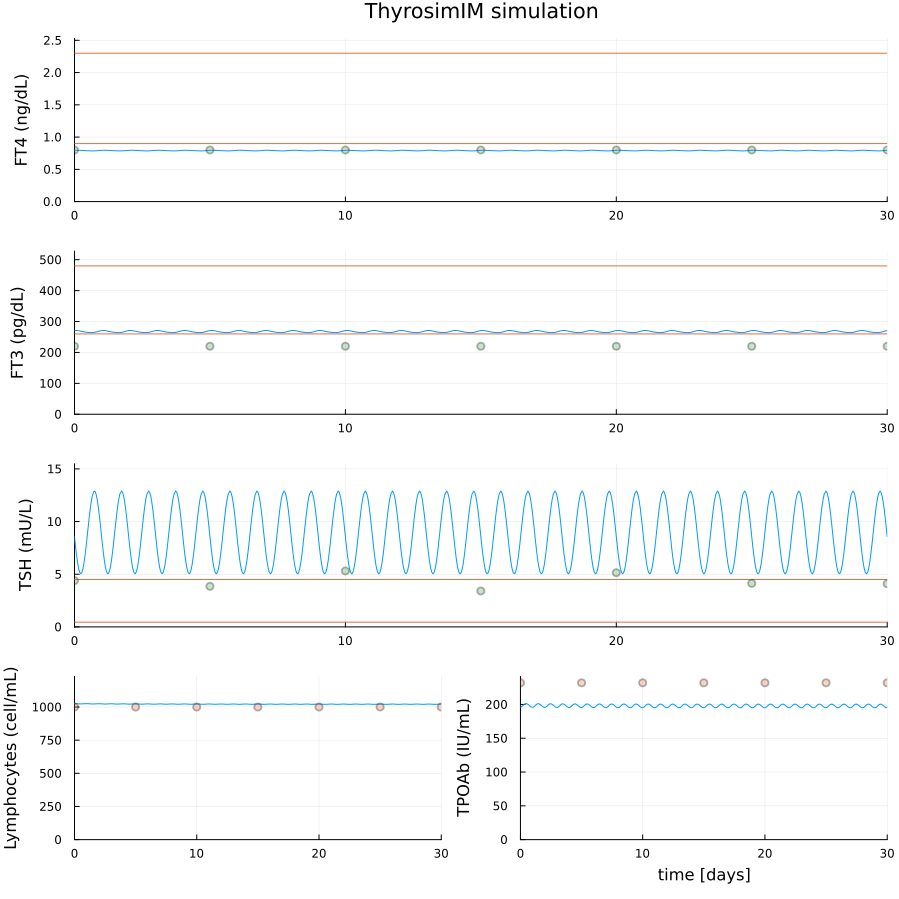

In [227]:
output_plotIM(sol, sample_IM)

In [230]:
vector = fitting_trial.minimizer

file = open("optimal_params.txt", "w")
write(file, join(vector, ","))
close(file)

### Statistics

Estimated variances: [3.3877913882377584, 1.1805683651080532, 1.5179794745931277, 3.61182232814787, 1.00872668736427, -0.7726467674141038, -0.35243292431286094, -0.3686313249341252, 0.7160313350893045]

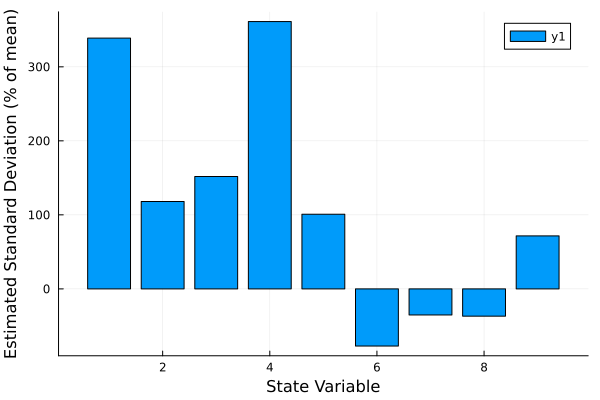

In [108]:
print("Estimated variances: ", fitting_trial.minimizer[18:26])
bar(100*fitting_trial.minimizer[18:26], xlabel = "State Variable", ylabel = "Estimated Standard Deviation (% of mean)")

In [98]:
function symlog(x::Number, base::Real = 10)
    if x == 0
        return 0.0
    else
        sign_x = sign(x)
        return sign_x * (log(abs(x)) / log(base) + 1)
    end
end

function normalize_matrix(matrix)
    D = Diagonal((sqrt.((diag(matrix)))))
    return inv(D)*matrix*inv(D)
end

function CV_estimation(
    free_parameters_guess::Vector,
    fixed_parameters::Vector,
    lb::Vector,
    ub::Vector,
    data::DataFrame;
    free_indicies::Vector=[],
    loss_function::Function=demeaned_neg_logl,
    variances::Vector=[])

    if isempty(free_indicies)
        fixed_indicies = collect(eachindex(fixed_parameters))
        free_indicies = setdiff(1:(size(fixed_indicies,1)+size(free_parameters_guess,1)), fixed_indicies)
    end

    optimal_sol = optimize(free_params -> objective(free_params, fixed_parameters,
        lb, ub, data, free_indicies=free_indicies, loss_function=lsq_loss),
        free_parameters_guess, Newton(), 
        Optim.Options(time_limit = 100.0, iterations = 0, g_tol=1e-5,
        show_trace = true, allow_f_increases=true, extended_trace=true))

    return optimal_sol
    #---------------------------------------------------#
    hessian = optimal_sol.trace[end].metadata["h(x)"]

    inv_hessian = try
        inv(hessian)
        return inv(hessian)
    catch problem
        if typeof(problem) == SingularException
            println("Inversion failed. Hessian is singular")
            return hessian
        else
            println(problem)
        end
    end
end

CV_estimation (generic function with 1 method)

In [14]:
# trace is not storing
CV_estimate = CV_estimation(MLE_trial.minimizer, fixed_params, lb, ub, sample_IM)

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Aidan\.julia\packages\SciMLBase\qp2gL\src\integrator_interface.jl:606


Iter     Function value   Gradient norm 


     0     7.926845e-01     1.066695e+77


 * Current step size: 1.0
 * time: 0.03600001335144043


 * g(x): [-1.0666948378041449e77, 6.283108163461921e23, -1.2610459750028964, -8.955448433074778e-8, -6.326942160919639e-7, 6.233806015691657e-7, 1.5534497960167626e24, 646.8274489082264, -1784.944882334411, 2.073031120468903, -0.43398880783862515, 34.78132965702819, 8.176280639757341e-10, -4.821353010182917e-10, -0.0019785924082800677, 1751.9000464300275, -0.1879333159520298, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


 * h(x): [1.9726016631692937e85 -9.725827158585155e84 -4.5425491337888347e83 3.608997555551298e75 -1.2881280520437482e77 2.6051048118885696e77 -1.9785941477068508e84 -2.976988520738028e84 4.7006295064931425e84 -1.0529358484562626e83 2.291576463958757e84 -2.1340773875373416e84 2.48518260354543e74 -1.2568615980569431e74 1.3632419687024944e80 -4.304505317460572e84 -9.169655028146503e82 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; -9.725827158585155e84 1.5737170493574806e84 -2.8943685281913804e82 3.8556811891073646e74 -1.5786525067159838e76 1.612401114668581e76 9.035067984777956e83 -1.5690729242026202e84 1.7218901691740982e84 -1.1170572716647337e82 4.4904471185383483e83 -5.488423609715141e83 2.879871184833221e73 -1.2673707303721887e73 4.599611800502776e79 -1.956185097255702e84 -4.927438022553588e81 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; -4.5425491337888347e83 -2.8943685281913804e82 375681.94641750347 -0.00334873240668576 0.2261292685709687 -0.21217145387902084 -2.158678029094298e81 8.069476548487765

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     7.926845e-01

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = 1.07e+77 ≰ 1.0e-05

 * Work counters
    Seconds run:   0  (vs limit 100)
    Iterations:    0
    f(x) calls:    1
    ∇f(x) calls:   1
    ∇²f(x) calls:  1


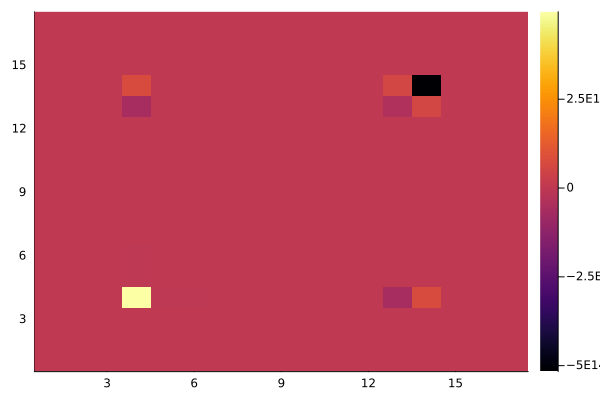

In [15]:
hess =  [5.086557062738764e7 -8.975713692101836e6 87721.39468827844 -0.0036138344026879496 -0.004169109330508855 0.0412036237380619 -1.4741641705452278e7 -1.415220801524967e6 -7.232587228557631e6 97680.68759578466 -3.4710551742016673e6 -1.2503822688478678e6 -1.881212748622513e-5 4.331103635188448e-6 3.717592557237433 7.230866191354491e6 602.5332329299303 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; -8.975713692101836e6 2.3930191218268275e6 -20097.328623734415 0.0003923179193011434 -0.005702890229865123 0.00109862469334632 2.687370977333255e6 72092.9356058985 1.7620193666359484e6 -10598.562122166157 380617.8766720593 -146853.3437903449 3.3888286380636282e-6 -9.963711336140634e-7 -0.6646151759412562 -1.7616235209487602e6 -667.0786293996368 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 87721.39468827844 -20097.328623734415 750.672917753458 2.451237397663043e-5 0.00025870663443813716 -0.00010778125292582822 -23102.843414500356 -739.7527782619 -65890.18403806537 -661.2209930941463 -10650.256822027266 5136.194780535996 -4.774654266178749e-8 5.347429588044037e-8 0.0047717281398648665 65876.77626981586 30.51001457507274 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; -0.0036138344026879496 0.0003923179193011434 2.451237397663043e-5 3.7740491955714115e-12 1.3289680219908628e-11 -1.1213298719172559e-11 0.0010989686844880939 0.0001725876146888288 -0.002218383926238594 -0.00010190227955872488 -5.469275126444685e-5 0.0004003325135622783 1.6022983112864047e-15 1.0962444990413473e-15 -3.214441567402506e-10 0.0022179522033147886 1.40538491564446e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; -0.004169109330508855 -0.005702890229865123 0.00025870663443813716 1.3289680219908628e-11 2.993690506020081e-10 -2.69838687212555e-10 0.00550916791580176 0.0028076686020824825 -0.022471410432890544 -0.00035778696769167963 0.0034826519446613667 0.013925580041970174 -1.4079480183592112e-14 1.079784841512541e-14 -2.1837999003654676e-9 0.022467118268054004 2.5202451068291327e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0412036237380619 0.00109862469334632 -0.00010778125292582822 -1.1213298719172559e-11 -2.69838687212555e-10 3.5406467205514226e-10 -0.016286833474311473 -0.0043299566883707955 0.009761417935795439 0.0003025928484137311 -0.014160916558547974 -0.0176806906348114 -3.497897195888835e-14 6.641231465469611e-16 4.862481015239555e-9 -0.009759907459329314 -2.2600903165785402e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; -1.4741641705452278e7 2.687370977333255e6 -23102.843414500356 0.0010989686844880939 0.00550916791580176 -0.016286833474311473 4.644851291599363e6 486567.7247246951 1.9976845998971164e6 -29662.864569440484 1.2673957838366851e6 735324.77851668 6.0310082873064206e-6 -1.2357312008009603e-6 -1.2003011311370468 -1.9972979332661182e6 178.05964930550965 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; -1.415220801524967e6 72092.9356058985 -739.7527782619 0.0001725876146888288 0.0028076686020824825 -0.0043299566883707955 486567.7247246951 103078.4431964457 60341.5835371837 -4655.433536320925 223045.68682068586 224004.38903275877 6.492790297502281e-7 -4.731602464144343e-8 -0.13250625956622333 -60318.0732857883 210.64186184721967 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; -7.232587228557631e6 1.7620193666359484e6 -65890.18403806537 -0.002218383926238594 -0.022471410432890544 0.009761417935795439 1.9976845998971164e6 60341.5835371837 5.970408869574159e6 59944.72408031672 975538.2786943838 -381839.63761492074 2.02773131710917e-6 -2.9548708244668235e-6 -0.3933077883961503 -5.974979799566187e6 -2695.85752319522 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 97680.68759578466 -10598.562122166157 -661.2209930941463 -0.00010190227955872488 -0.00035778696769167963 0.0003025928484137311 -29662.864569440484 -4655.433536320925 59944.72408031672 2752.6258061528206 1494.0702605694532 -10707.777468673885 -6.28709012690057e-8 -2.957558261059313e-8 0.00861091552552933 -59932.93724831939 -37.919711838344426 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; -3.4710551742016673e6 380617.8766720593 -10650.256822027266 -5.469275126444685e-5 0.0034826519446613667 -0.014160916558547974 1.2673957838366851e6 223045.68682068586 975538.2786943838 1494.0702605694532 1.3028874911199808e6 822699.3145102784 1.5488955231148387e-6 -5.705556134287418e-7 -0.33215028836706023 -975311.4825131148 254.53371396703244 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; -1.2503822688478678e6 -146853.3437903449 5136.194780535996 0.0004003325135622783 0.013925580041970174 -0.0176806906348114 735324.77851668 224004.38903275877 -381839.63761492074 -10707.777468673885 822699.3145102784 1.1612692013696134e6 9.76768816520486e-7 1.851410780218829e-7 -0.2164905428188198 381766.07608529925 1085.0214320034963 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; -1.881212748622513e-5 3.3888286380636282e-6 -4.774654266178749e-8 1.6022983112864047e-15 -1.4079480183592112e-14 -3.497897195888835e-14 6.0310082873064206e-6 6.492790297502281e-7 2.02773131710917e-6 -6.28709012690057e-8 1.5488955231148387e-6 9.76768816520486e-7 -4.151742171680194e-14 -2.739666586595205e-15 2.64883661556531e-11 -2.0483277471077734e-6 6.098953233676943e-10 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 4.331103635188448e-6 -9.963711336140634e-7 5.347429588044037e-8 1.0962444990413473e-15 1.079784841512541e-14 6.641231465469611e-16 -1.2357312008009603e-6 -4.731602464144343e-8 -2.9548708244668235e-6 -2.957558261059313e-8 -5.705556134287418e-7 1.851410780218829e-7 -2.739666586595205e-15 -2.2137375304422536e-15 2.9254659103647343e-13 2.9678318079693374e-6 1.2662622812313162e-9 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 3.717592557237433 -0.6646151759412562 0.0047717281398648665 -3.214441567402506e-10 -2.1837999003654676e-9 4.862481015239555e-9 -1.2003011311370468 -0.13250625956622333 -0.3933077883961503 0.00861091552552933 -0.33215028836706023 -0.2164905428188198 2.64883661556531e-11 2.9254659103647343e-13 2.7190633271177427e-7 0.3931929275235566 -0.0001355286701648965 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 7.230866191354491e6 -1.7616235209487602e6 65876.77626981586 0.0022179522033147886 0.022467118268054004 -0.009759907459329314 -1.9972979332661182e6 -60318.0732857883 -5.974979799566187e6 -59932.93724831939 -975311.4825131148 381766.07608529925 -2.0483277471077734e-6 2.9678318079693374e-6 0.3931929275235566 5.9680625967901945e6 2695.3544289995575 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 602.5332329299303 -667.0786293996368 30.51001457507274 1.40538491564446e-6 2.5202451068291327e-5 -2.2600903165785402e-5 178.05964930550965 210.64186184721967 -2695.85752319522 -37.919711838344426 254.53371396703244 1085.0214320034963 6.098953233676943e-10 1.2662622812313162e-9 -0.0001355286701648965 2695.3544289995575 2.791544519044679 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
heatmap((inv(hess[1:17, 1:17])))

In [16]:
CV_df = DataFrame(CV_estimate, :auto)
no_parameters = 26

grid = 0.5:1:(no_parameters+0.5)
borders = collect(grid)
Estim_CV = inv(Hessian)
heatmap(symlog.(Estim_CV), c=:vik, title="Hessian")
xlabel!("Immune Parameters")
ylabel!("Immune Parameters")
xlims!((0.5,no_parameters+0.5)); ylims!((0.5,no_parameters+0.5))
xticks!(0:1:no_parameters); yticks!(0:1:no_parameters)
vline!(borders, c=:black, label=""); hline!(borders, c=:black, label="")

MethodError: MethodError: no method matching DataFrame(::Optim.MultivariateOptimizationResults{Newton{LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}}, Vector{Float64}, Float64, Float64, Vector{OptimizationState{Float64, Newton{LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}}}}, Bool, NamedTuple{(:f_limit_reached, :g_limit_reached, :h_limit_reached, :time_limit, :callback, :f_increased), NTuple{6, Bool}}}, ::Symbol)

Closest candidates are:
  DataFrame(!Matched::AbstractVector, ::Symbol; copycols)
   @ DataFrames C:\Users\Aidan\.julia\packages\DataFrames\LteEl\src\dataframe\dataframe.jl:361
  DataFrame(!Matched::AbstractMatrix, ::Symbol; copycols)
   @ DataFrames C:\Users\Aidan\.julia\packages\DataFrames\LteEl\src\dataframe\dataframe.jl:382
  DataFrame(::T; copycols) where T
   @ DataFrames C:\Users\Aidan\.julia\packages\DataFrames\LteEl\src\other\tables.jl:48


In [17]:
corr = normalize_matrix(abs.(CV_estimate))
heatmap(corr, c=:vik, title="Correlation Matrix")
xlabel!("Immune Parameters")
ylabel!("Immune Parameters")
xlims!((0.5,no_parameters+0.5)); ylims!((0.5,no_parameters+0.5))
xticks!(0:1:no_parameters); yticks!(0:1:no_parameters)
vline!(borders, c=:black, label=""); hline!(borders, c=:black, label="")

MethodError: MethodError: no method matching length(::Optim.MultivariateOptimizationResults{Newton{LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}}, Vector{Float64}, Float64, Float64, Vector{OptimizationState{Float64, Newton{LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}}}}, Bool, NamedTuple{(:f_limit_reached, :g_limit_reached, :h_limit_reached, :time_limit, :callback, :f_increased), NTuple{6, Bool}}})

Closest candidates are:
  length(!Matched::Union{Base.KeySet, Base.ValueIterator})
   @ Base abstractdict.jl:58
  length(!Matched::Union{SparseArrays.FixedSparseVector{Tv, Ti}, SparseArrays.SparseVector{Tv, Ti}} where {Tv, Ti})
   @ SparseArrays C:\Users\Aidan\AppData\Local\Programs\Julia-1.9.0\share\julia\stdlib\v1.9\SparseArrays\src\sparsevector.jl:95
  length(!Matched::Union{ArrayInterface.BidiagonalIndex, ArrayInterface.TridiagonalIndex})
   @ ArrayInterface C:\Users\Aidan\.julia\packages\ArrayInterface\ylEpB\src\ArrayInterface.jl:808
  ...
